Bu notebook içerisinde Covid19 Pandemi Döneminde Yatan Hastaların durumlarıyla alakalı küçük bir veri seti paylaşılmıştır. Sizden beklenenler:
- Veriyi excel dosyasından okumak
- Veri hakkında EDA sürecini uygulamak
- Gözlemlerinizi belirtmek 
- Preprocessing adımlarını uygulamak
- FIM ve Association rule Extaction
- Sonuçları değerlendirmek

- pip install xlrd
- pip install pandas
- pip install numpy
- pip install mlxtend
- pip install scikit-learn
- pip install matplotlib
- pip install seaborn 

# 1. Import Libraries

- NumPy, Pandas gibi paketlerin import edilmesi

In [1]:
# import subprocess

# libraries = ['xlrd', 'pandas', 'numpy', 'mlxtend', 'scikit-learn', 'matplotlib', 'seaborn', 'openpyxl']

# for library in libraries:
#     subprocess.call(['pip', 'install', library])

Subprocess kütüphanesi, işletim sistemi komutları ile etkileşim kurarak Python programlarının dış işlemlerini yönetir.

In [2]:
# Kütüphaneleri import et
import xlrd
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn import *
import matplotlib.pyplot as plt
import seaborn as sns

print("Kütüphaneler başarıyla yüklendi ve import edildi.")

Kütüphaneler başarıyla yüklendi ve import edildi.


# 2. Load Dataset
- excel dosyasının içindeki "data_reduced" sheet'ini oku

In [3]:
workbook = xlrd.open_workbook("COVID19 inpatient cases data.xls") # Excel dosyasını aç
worksheet = workbook.sheet_by_name("data_reduced") # Excel çalışma sayfasını seç

data = []

# Çalışma sayfasının her bir satırını döngü ile gez
for row_index in range(worksheet.nrows):
    row = worksheet.row_values(row_index)
    data.append(row) # Satırı "data" listesine ekle
    
# "data" listesini kullanarak bir DataFrame oluştur
df = pd.DataFrame(data, columns=data[0])
df= df.iloc[1:] # İlk satırı sütun başlıkları olarak kabul edildiğinden çıkarılır (Knime içinde column names ayarı)
df

,Gender,Age,Clinical classification,Days from symptoms to hospital,No comorbidity,Cardiovascular and\ncerebrovascular disease,Endocrine system disease,Malignant tumor,Respiratory system disease,Digestive system disease,Renal disease,Liver disease,Fever,Cough,Chest tightness,Fatigue,Diarrhea,Others,Clinical outcome,"Hospital stay, days"
1,Male,47.0,Heavy,15.0,Y,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,N,"Aggravated,turn to ICU",NA
2,Female,53.0,Ordinary,13.0,Y,N,N,N,N,N,N,N,Y,Y,Y,N,N,N,Improved and discharge,6.0
3,Female,57.0,Ordinary,13.0,Y,N,N,N,N,N,N,N,Y,Y,N,N,N,N,Improved and discharge,8.0
4,Male,58.0,Heavy,1.0,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,"Aggravated,transfer to superior hospital",NA
5,Male,54.0,Ordinary,10.0,Y,N,N,N,N,N,N,N,Y,Y,Y,N,N,N,Improved and discharge,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,Female,30.0,Ordinary,13.0,Y,N,N,N,N,N,N,N,Y,Y,N,N,N,N,Improved and discharge,24.0
70,Female,59.0,Ordinary,10.0,N,N,Y,N,N,N,N,N,N,Y,N,Y,N,N,Improved and discharge,16.0
71,Female,87.0,Ordinary,10.0,N,Y,N,N,N,N,N,N,N,Y,N,N,N,N,Improved and discharge,14.0
72,Female,56.0,Ordinary,20.0,N,Y,N,N,N,N,N,N,Y,Y,N,N,N,N,Improved and discharge,12.0


# 3. Exploratory Data Analysis 

- Görselleştirme ve analiz gerçekleştirilip, yorumlarda bulunulması bekleniyor

Hastalıklar hakkında nominal veriler içeren 73 gözlem sayısına sahip bir veri setine sahibiz. Gender, Age, Clinical Classification, Days from symptoms to hospital, No comorbidity, 7 disease, 6 symptoms, Clinical outcome, Hospital stay, days sütunlarından oluşan 20 değişkenimiz var.

### Veri tipleri

In [4]:
# Veri setindeki değişken ve gözlem sayısı
print("Gözlem sayısı : " ,len(df))
print("Değişken sayısı : ", len(df.columns))

Gözlem sayısı :  73
Değişken sayısı :  20


In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 1 to 73
Data columns (total 20 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   Gender                                      73 non-null     object
 1   Age                                         73 non-null     object
 2   Clinical classification                     73 non-null     object
 3   Days from symptoms to hospital              73 non-null     object
 4   No comorbidity                              73 non-null     object
 5   Cardiovascular and
cerebrovascular disease  73 non-null     object
 6   Endocrine system disease                    73 non-null     object
 7   Malignant tumor                             73 non-null     object
 8   Respiratory system disease                  73 non-null     object
 9   Digestive system disease                    73 non-null     object
 10  Renal disease               

### Kategorik Değişken Analizi

In [6]:
### List comprehension yöntemi
# Tüm sütunların adlarını içeren bir listeyi döndürerek df'in her bir sütunun veri tipini kontrol eder.
# Eğer sütunun veri tipi "O" (object) ise, o sütunu "cat_cols" listesine ekler.
cat_cols = [col for col in df.columns if df[col].dtype=="O"]

In [7]:
### Kaç adet kategorik değişkenimiz var?
len(cat_cols)

20

<AxesSubplot:title={'center':'Değişken Sınıfları'}>

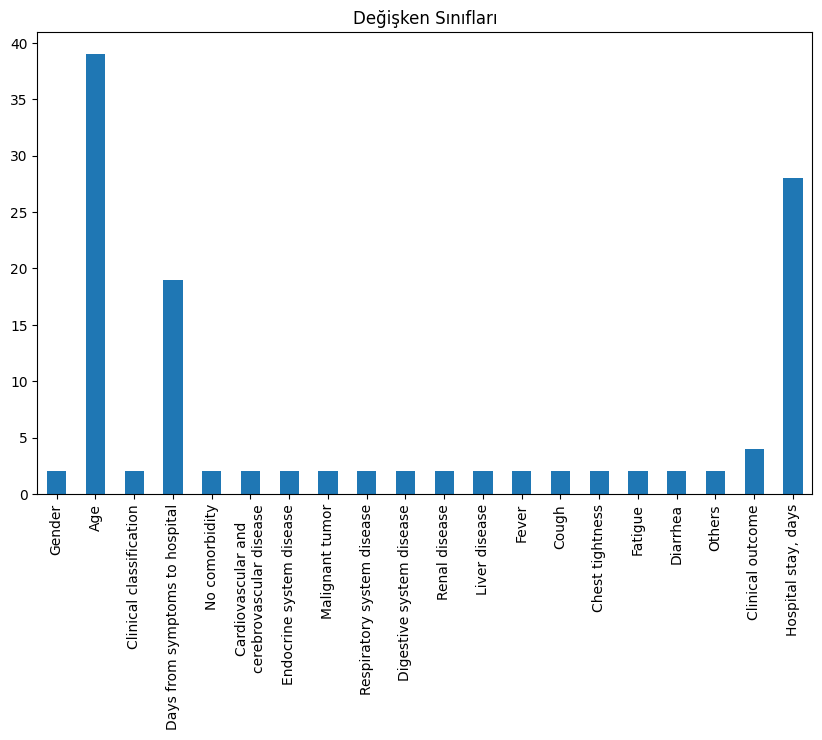

In [8]:
# nunique() işlevi, her bir sütundaki benzersiz değerlerin sayısını hesaplar.
unique_counts = df[cat_cols].nunique()
# unique_counts.index, sütun adlarını içeren bir indeks nesnesidir.
# unique_counts.values, benzersiz değer sayılarını içeren bir dizi nesnesidir.
unique_counts.plot(kind='bar', figsize=(10, 6), title='Değişken Sınıfları')

### Convertion

In [9]:
# Veri türü dönüşümleri (Object to integer)
df["Age"] = df["Age"].astype('Int64')
df["Days from symptoms to hospital"] = df["Days from symptoms to hospital"].astype('Int64')
df["Hospital stay, days"] = df["Hospital stay, days"].replace("NA", np.nan).astype('Int64')

df.info()  # Veri seti bilgisini göster
df.head()  # İlk beş gözlemi göster

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 1 to 73
Data columns (total 20 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   Gender                                      73 non-null     object
 1   Age                                         73 non-null     Int64 
 2   Clinical classification                     73 non-null     object
 3   Days from symptoms to hospital              73 non-null     Int64 
 4   No comorbidity                              73 non-null     object
 5   Cardiovascular and
cerebrovascular disease  73 non-null     object
 6   Endocrine system disease                    73 non-null     object
 7   Malignant tumor                             73 non-null     object
 8   Respiratory system disease                  73 non-null     object
 9   Digestive system disease                    73 non-null     object
 10  Renal disease               

,Gender,Age,Clinical classification,Days from symptoms to hospital,No comorbidity,Cardiovascular and\ncerebrovascular disease,Endocrine system disease,Malignant tumor,Respiratory system disease,Digestive system disease,Renal disease,Liver disease,Fever,Cough,Chest tightness,Fatigue,Diarrhea,Others,Clinical outcome,"Hospital stay, days"
1,Male,47,Heavy,15,Y,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,N,"Aggravated,turn to ICU",<NA>
2,Female,53,Ordinary,13,Y,N,N,N,N,N,N,N,Y,Y,Y,N,N,N,Improved and discharge,6
3,Female,57,Ordinary,13,Y,N,N,N,N,N,N,N,Y,Y,N,N,N,N,Improved and discharge,8
4,Male,58,Heavy,1,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,"Aggravated,transfer to superior hospital",<NA>
5,Male,54,Ordinary,10,Y,N,N,N,N,N,N,N,Y,Y,Y,N,N,N,Improved and discharge,5


### NaN, Kayıp değer

In [10]:
#Train setindeki tüm değişkenlere bakış
df.describe(include = "all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Gender,73,2,Male,37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,73.0,NaN,NaN,NaN,55.671233,15.136467,21.0,46.0,57.0,68.0,87.0
Clinical classification,73,2,Ordinary,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Days from symptoms to hospital,73.0,NaN,NaN,NaN,10.260274,7.514851,1.0,4.0,9.0,14.0,40.0
No comorbidity,73,2,Y,39,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cardiovascular and\ncerebrovascular disease,73,2,N,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Endocrine system disease,73,2,N,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Malignant tumor,73,2,N,69,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Respiratory system disease,73,2,N,72,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Digestive system disease,73,2,N,72,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df.describe()

,Age,Days from symptoms to hospital,"Hospital stay, days"
count,73.000000,73.000000,69.000000
mean,55.671233,10.260274,15.188406
std,15.136467,7.514851,8.430120
min,21.000000,1.000000,4.000000
25%,46.000000,4.000000,8.000000
50%,57.000000,9.000000,13.000000
75%,68.000000,14.000000,22.000000
max,87.000000,40.000000,36.000000


In [12]:
# Her veri seti için kayıp değer sayılarını bul
missing_values = df.isnull().sum()
print("missing_values:", missing_values)

missing_values: Gender                                         0
Age                                            0
Clinical classification                        0
Days from symptoms to hospital                 0
No comorbidity                                 0
Cardiovascular and\ncerebrovascular disease    0
Endocrine system disease                       0
Malignant tumor                                0
Respiratory system disease                     0
Digestive system disease                       0
Renal disease                                  0
Liver disease                                  0
Fever                                          0
Cough                                          0
Chest tightness                                0
Fatigue                                        0
Diarrhea                                       0
Others                                         0
Clinical outcome                               0
Hospital stay, days                            4
dtyp

In [13]:
mean_hospital_stay = df["Hospital stay, days"].mean()
rounded_mean_hospital_stay = round(mean_hospital_stay)
df["Hospital stay, days"].fillna(rounded_mean_hospital_stay, inplace=True)

In [14]:
missing_values = df.isnull().sum()
print("missing_values:", missing_values)

missing_values: Gender                                         0
Age                                            0
Clinical classification                        0
Days from symptoms to hospital                 0
No comorbidity                                 0
Cardiovascular and\ncerebrovascular disease    0
Endocrine system disease                       0
Malignant tumor                                0
Respiratory system disease                     0
Digestive system disease                       0
Renal disease                                  0
Liver disease                                  0
Fever                                          0
Cough                                          0
Chest tightness                                0
Fatigue                                        0
Diarrhea                                       0
Others                                         0
Clinical outcome                               0
Hospital stay, days                            0
dtyp

### Tekrarlı Değerler

In [15]:
# Veri setindeki tekrarlı değerleri bul
duplicate_count = df[df.duplicated()].sum()
# Tekrarlı değerleri yazdır
print("Veri Setinde Tekrarlı Satır Sayısı:", df.duplicated().sum(), "\n", duplicate_count)

Veri Setinde Tekrarlı Satır Sayısı: 0 
 Gender                                         0.0
Age                                            0.0
Clinical classification                        0.0
Days from symptoms to hospital                 0.0
No comorbidity                                 0.0
Cardiovascular and\ncerebrovascular disease    0.0
Endocrine system disease                       0.0
Malignant tumor                                0.0
Respiratory system disease                     0.0
Digestive system disease                       0.0
Renal disease                                  0.0
Liver disease                                  0.0
Fever                                          0.0
Cough                                          0.0
Chest tightness                                0.0
Fatigue                                        0.0
Diarrhea                                       0.0
Others                                         0.0
Clinical outcome                          

### Veri setindeki dağılımlar/dengesizlikler

             Age  Days from symptoms to hospital  Hospital stay, days
count  73.000000                       73.000000            73.000000
mean   55.671233                       10.260274            15.178082
std    15.136467                        7.514851             8.192718
min    21.000000                        1.000000             4.000000
25%    46.000000                        4.000000             8.000000
50%    57.000000                        9.000000            14.000000
75%    68.000000                       14.000000            21.000000
max    87.000000                       40.000000            36.000000


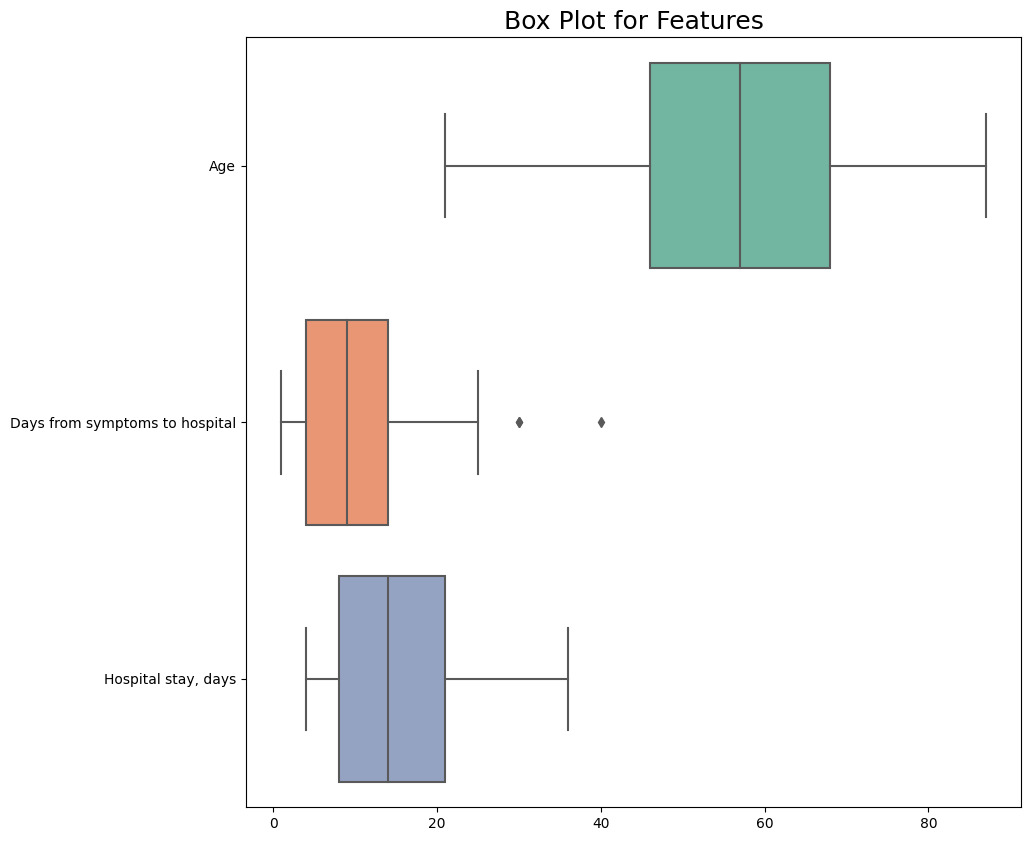

In [16]:
plt.figure(figsize=(10,10))
plt.title('Box Plot for Features', fontdict={'fontsize':18})
ax = sns.boxplot(data=df, orient="h", palette="Set2")
print(df.describe())

In [17]:
Q1 = df["Days from symptoms to hospital"].quantile(0.25)
Q3 = df["Days from symptoms to hospital"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [18]:
outliers_count = len(df[(df["Days from symptoms to hospital"] < lower_bound) | (df["Days from symptoms to hospital"] > upper_bound)])
print("Aykırı Değer Sayısı:", outliers_count)

Aykırı Değer Sayısı: 3


In [19]:
df = df[(df["Days from symptoms to hospital"] >= lower_bound) & (df["Days from symptoms to hospital"] <= upper_bound)]

# Aykırı 3 değeri filtreledikten sonra Indexleri sıfırla
# Indexleri sıfırlamak ve 1'den başlatmak
df.reset_index(drop=True, inplace=True)
df.index = df.index + 1
df

,Gender,Age,Clinical classification,Days from symptoms to hospital,No comorbidity,Cardiovascular and\ncerebrovascular disease,Endocrine system disease,Malignant tumor,Respiratory system disease,Digestive system disease,Renal disease,Liver disease,Fever,Cough,Chest tightness,Fatigue,Diarrhea,Others,Clinical outcome,"Hospital stay, days"
1,Male,47,Heavy,15,Y,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,N,"Aggravated,turn to ICU",15
2,Female,53,Ordinary,13,Y,N,N,N,N,N,N,N,Y,Y,Y,N,N,N,Improved and discharge,6
3,Female,57,Ordinary,13,Y,N,N,N,N,N,N,N,Y,Y,N,N,N,N,Improved and discharge,8
4,Male,58,Heavy,1,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,"Aggravated,transfer to superior hospital",15
5,Male,54,Ordinary,10,Y,N,N,N,N,N,N,N,Y,Y,Y,N,N,N,Improved and discharge,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,Female,30,Ordinary,13,Y,N,N,N,N,N,N,N,Y,Y,N,N,N,N,Improved and discharge,24
67,Female,59,Ordinary,10,N,N,Y,N,N,N,N,N,N,Y,N,Y,N,N,Improved and discharge,16
68,Female,87,Ordinary,10,N,Y,N,N,N,N,N,N,N,Y,N,N,N,N,Improved and discharge,14
69,Female,56,Ordinary,20,N,Y,N,N,N,N,N,N,Y,Y,N,N,N,N,Improved and discharge,12


IQR yöntemi, verinin çeyreklerine dayalı bir yaklaşım kullanarak aykırı değerleri tespit eder. Bu yöntemde, Q1 ve Q3 değerleri hesaplanır ve IQR (Q3 - Q1) değeri bulunur. Ardından, IQR değeri kullanılarak alt ve üst eşik değerleri belirlenir. Bu yöntemle, alt ve üst eşik değerleri dışında kalan değerler aykırı değer olarak kabul edilir. Verimizi IQR (Interquartile Range) yöntemi kullanarak filtreledik.

             Age  Days from symptoms to hospital  Hospital stay, days
count  70.000000                       70.000000             70.00000
mean   56.014286                        9.271429             15.60000
std    14.840693                        5.815824              8.10153
min    23.000000                        1.000000              4.00000
25%    46.250000                        4.000000              9.00000
50%    57.500000                        9.000000             14.50000
75%    68.000000                       13.000000             21.75000
max    87.000000                       25.000000             36.00000


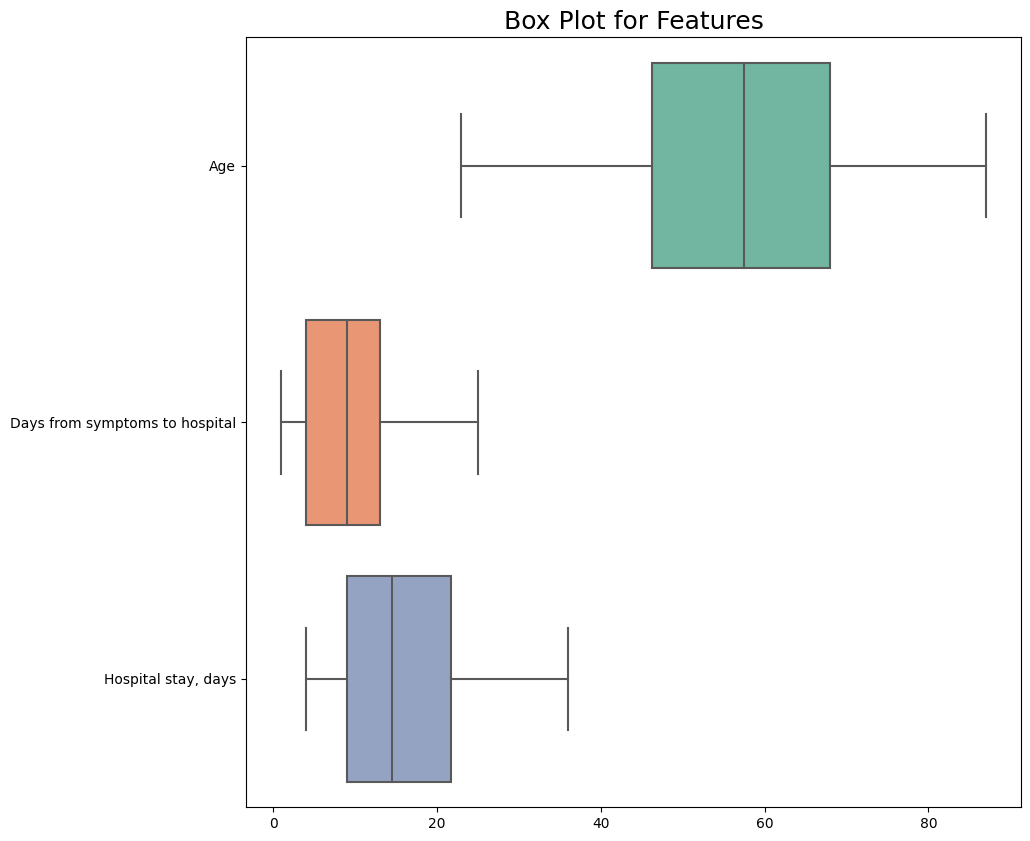

In [20]:
plt.figure(figsize=(10,10))
plt.title('Box Plot for Features', fontdict={'fontsize':18})
ax = sns.boxplot(data=df, orient="h", palette="Set2")
print(df.describe())

# 4. Preprocessing 

## 4.1. Hastalıklar DataFrame'inin Oluşturulması
- df_diseases dataframe'ini şu sütunları ana dataframe'den seçerek oluştur: **['Cardiovascular and\ncerebrovascular disease', 'Endocrine system disease','Malignant tumor','Respiratory system disease', 'Digestive system disease','Renal disease','Liver disease']**
- df_diseases dataframe'ine ana dataframe içerisindeki şu sütunları ekle:**['Age','Gender']**
- df_diseases dataframe'ine **Illness** diye bir sütun oluştur ve bu sütunu ana dataframe'deki **Clinical classification** sütunu ile doldur ve her doldurdugun her verinin sonuna **' ill'** ekle
- **'Age Group'** diye bir sütun oluştur ve **'Age'** sütunundaki verilere göre şu şekilde kategorize et: <br>
    **{"Elderly": (Age>=65),<br> "Adults": (18<= Age <65),<br>"Teens": (12=<Age<18), <br>"Children": (1<Age<11), <br> "Infants": (Age<=1) }**
- Kategorizasyon bittikten sonra **'Age'** sütununu drop et
- **"Gender", "Illness", "Age Group"** sütunlarını one-hot encoding için dummy hale getir 
- **"Gender", "Illness", "Age Group"** drop et
- Tüm veriyi boolean(True,False) hale getir.**{'Y': True, 'N': False}**

In [21]:
# df_diseases'i oluşturma
selected_disease_columns = [
    'Cardiovascular and\ncerebrovascular disease', 'Endocrine system disease',
    'Malignant tumor', 'Respiratory system disease', 'Digestive system disease',
    'Renal disease', 'Liver disease'
]

df_diseases = df[selected_disease_columns].copy()
df_diseases

,Cardiovascular and\ncerebrovascular disease,Endocrine system disease,Malignant tumor,Respiratory system disease,Digestive system disease,Renal disease,Liver disease
1,N,N,N,N,N,N,N
2,N,N,N,N,N,N,N
3,N,N,N,N,N,N,N
4,N,Y,N,N,N,N,N
5,N,N,N,N,N,N,N
...,...,...,...,...,...,...,...
66,N,N,N,N,N,N,N
67,N,Y,N,N,N,N,N
68,Y,N,N,N,N,N,N
69,Y,N,N,N,N,N,N


- df_diseases dataframe'ine ana dataframe içerisindeki şu sütunları ekle:**['Age','Gender']**

In [22]:
df_diseases["Age"] = df["Age"].copy()
df_diseases["Gender"] = df["Gender"].copy()
df_diseases

,Cardiovascular and\ncerebrovascular disease,Endocrine system disease,Malignant tumor,Respiratory system disease,Digestive system disease,Renal disease,Liver disease,Age,Gender
1,N,N,N,N,N,N,N,47,Male
2,N,N,N,N,N,N,N,53,Female
3,N,N,N,N,N,N,N,57,Female
4,N,Y,N,N,N,N,N,58,Male
5,N,N,N,N,N,N,N,54,Male
...,...,...,...,...,...,...,...,...,...
66,N,N,N,N,N,N,N,30,Female
67,N,Y,N,N,N,N,N,59,Female
68,Y,N,N,N,N,N,N,87,Female
69,Y,N,N,N,N,N,N,56,Female


- df_diseases dataframe'ine **Illness** diye bir sütun oluştur ve bu sütunu ana dataframe'deki **Clinical classification** sütunu ile doldur ve her doldurdugun her verinin sonuna **' ill'** ekle

In [23]:
# "Illness" sütununu oluşturma
df_diseases["Illness"] = df["Clinical classification"].copy() + " ill"
df_diseases

,Cardiovascular and\ncerebrovascular disease,Endocrine system disease,Malignant tumor,Respiratory system disease,Digestive system disease,Renal disease,Liver disease,Age,Gender,Illness
1,N,N,N,N,N,N,N,47,Male,Heavy ill
2,N,N,N,N,N,N,N,53,Female,Ordinary ill
3,N,N,N,N,N,N,N,57,Female,Ordinary ill
4,N,Y,N,N,N,N,N,58,Male,Heavy ill
5,N,N,N,N,N,N,N,54,Male,Ordinary ill
...,...,...,...,...,...,...,...,...,...,...
66,N,N,N,N,N,N,N,30,Female,Ordinary ill
67,N,Y,N,N,N,N,N,59,Female,Ordinary ill
68,Y,N,N,N,N,N,N,87,Female,Ordinary ill
69,Y,N,N,N,N,N,N,56,Female,Ordinary ill


- **'Age Group'** diye bir sütun oluştur ve **'Age'** sütunundaki verilere göre şu şekilde kategorize et: <br>
    **{"Elderly": (Age>=65),<br> "Adults": (18<= Age <65),<br>"Teens": (12=<Age<18), <br>"Children": (1<Age<11), <br> "Infants": (Age<=1) }**

In [24]:
# 'Age Group' sütununu oluşturma ve yaşlara göre kategorilendirme
def categorize_age(age):
    if age >= 65:
        return 'Elderly'
    elif 18 <= age < 65:
        return 'Adults'
    elif 12 <= age < 18:
        return 'Teens'
    elif 1 < age < 11:
        return 'Children'
    elif age <= 1:
        return 'Infants'
    else:
        return 'Unknown'  # Belirtilen kategorilere uymayan değerler için

df_diseases['Age Group'] = df_diseases['Age'].apply(categorize_age)
df_diseases

,Cardiovascular and\ncerebrovascular disease,Endocrine system disease,Malignant tumor,Respiratory system disease,Digestive system disease,Renal disease,Liver disease,Age,Gender,Illness,Age Group
1,N,N,N,N,N,N,N,47,Male,Heavy ill,Adults
2,N,N,N,N,N,N,N,53,Female,Ordinary ill,Adults
3,N,N,N,N,N,N,N,57,Female,Ordinary ill,Adults
4,N,Y,N,N,N,N,N,58,Male,Heavy ill,Adults
5,N,N,N,N,N,N,N,54,Male,Ordinary ill,Adults
...,...,...,...,...,...,...,...,...,...,...,...
66,N,N,N,N,N,N,N,30,Female,Ordinary ill,Adults
67,N,Y,N,N,N,N,N,59,Female,Ordinary ill,Adults
68,Y,N,N,N,N,N,N,87,Female,Ordinary ill,Elderly
69,Y,N,N,N,N,N,N,56,Female,Ordinary ill,Adults


- Kategorizasyon bittikten sonra **'Age'** sütununu drop et

In [25]:
df_diseases.drop(['Age'], axis=1, inplace=True)
df_diseases

,Cardiovascular and\ncerebrovascular disease,Endocrine system disease,Malignant tumor,Respiratory system disease,Digestive system disease,Renal disease,Liver disease,Gender,Illness,Age Group
1,N,N,N,N,N,N,N,Male,Heavy ill,Adults
2,N,N,N,N,N,N,N,Female,Ordinary ill,Adults
3,N,N,N,N,N,N,N,Female,Ordinary ill,Adults
4,N,Y,N,N,N,N,N,Male,Heavy ill,Adults
5,N,N,N,N,N,N,N,Male,Ordinary ill,Adults
...,...,...,...,...,...,...,...,...,...,...
66,N,N,N,N,N,N,N,Female,Ordinary ill,Adults
67,N,Y,N,N,N,N,N,Female,Ordinary ill,Adults
68,Y,N,N,N,N,N,N,Female,Ordinary ill,Elderly
69,Y,N,N,N,N,N,N,Female,Ordinary ill,Adults


- **"Gender", "Illness", "Age Group"** sütunlarını one-hot encoding için dummy hale getir 

#### One Hot Encoding

##### get_dummies
get_dummies, genellikle pandas kütüphanesinde kullanılan bir fonksiyondur. Bu fonksiyon, verilen kategorik sütunları ayrı ayrı alır ve bu sütunların her bir değeri için ayrı bir sütun oluşturur. 

Amaç = Bir kategorik değişken 2 den fazla değere sahip olduğunda binary olarak bu sınıflara göre encoding yapılmasıdır.

* pd.get_dummies() fonksiyonu ile uygulanır başlıca parametreleri drop_first ve dummy_na dır
* drop_first=True yaptığımızda dummy tuzağına düşmemek için yaratılan ilk dummies sutunu düşürülür.
* dummy_na= True ise one hot encoding uygulanacak sutunda boş değer var ise fonksiyonun onu bir değer olarak görüp bir sutun olusturmasını sağlamaktadır.

##### OneHotEncoder
OneHotEncoder kullanırken, sadece dönüştürme işlemini yapar ve yeni sütunlar veri çerçevesine eklenmez. Bunun yerine, dönüştürülmüş veriyi ayrı bir ndarray veya sparse matrix olarak alırsınız.

In [26]:
from sklearn.preprocessing import OneHotEncoder
# OneHotEncoder örneği oluşturma
encoder = OneHotEncoder()
#encoder = OneHotEncoder(drop='first') # dummy tuzağını önleme (Gender_Male,Gender_Female yerine sadece Gender_Male)

# Kategorik sütunları seçme
categorical_columns = ["Gender", "Illness", "Age Group"]

# One-Hot Encoding işlemi
encoded_features = encoder.fit_transform(df_diseases[categorical_columns])

# Sütun isimlerini oluşturma
column_names = encoder.get_feature_names_out(input_features=categorical_columns)

# Dönüşüm sonuçlarını DataFrame'e dönüştürme
encoded_df = pd.DataFrame(encoded_features.toarray(), columns=column_names)

# Oluşturulan sütunları asıl veri çerçevesine eklemek
df_diseases = pd.concat([df_diseases.reset_index(drop=True), encoded_df], axis=1)
df_diseases.index = df_diseases.index + 1
df_diseases

,Cardiovascular and\ncerebrovascular disease,Endocrine system disease,Malignant tumor,Respiratory system disease,Digestive system disease,Renal disease,Liver disease,Gender,Illness,Age Group,Gender_Female,Gender_Male,Illness_Heavy ill,Illness_Ordinary ill,Age Group_Adults,Age Group_Elderly
1,N,N,N,N,N,N,N,Male,Heavy ill,Adults,0.0,1.0,1.0,0.0,1.0,0.0
2,N,N,N,N,N,N,N,Female,Ordinary ill,Adults,1.0,0.0,0.0,1.0,1.0,0.0
3,N,N,N,N,N,N,N,Female,Ordinary ill,Adults,1.0,0.0,0.0,1.0,1.0,0.0
4,N,Y,N,N,N,N,N,Male,Heavy ill,Adults,0.0,1.0,1.0,0.0,1.0,0.0
5,N,N,N,N,N,N,N,Male,Ordinary ill,Adults,0.0,1.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,N,N,N,N,N,N,N,Female,Ordinary ill,Adults,1.0,0.0,0.0,1.0,1.0,0.0
67,N,Y,N,N,N,N,N,Female,Ordinary ill,Adults,1.0,0.0,0.0,1.0,1.0,0.0
68,Y,N,N,N,N,N,N,Female,Ordinary ill,Elderly,1.0,0.0,0.0,1.0,0.0,1.0
69,Y,N,N,N,N,N,N,Female,Ordinary ill,Adults,1.0,0.0,0.0,1.0,1.0,0.0


In [27]:
# # Sütunları dummy encoding ile dönüştürme
# #dum_df = pd.get_dummies(df_diseases, columns=["Gender", "Illness", "Age Group"], prefix=["Gender", "Illness", "Age Group"])
# dum_df = pd.get_dummies(df_diseases, columns=["Gender", "Illness", "Age Group"], prefix=["Gender", "Illness", "Age Group"], drop_first=True)
# # merge with main df_diseases
# df_diseases = pd.concat([df_diseases, dum_df], axis=1)
# df_diseases

- **"Gender", "Illness", "Age Group"** drop et

In [28]:
# Dummy değişkenleri oluşturduktan sonra orinal ilk sütunları çıkararak dummy tuzağından kaçın
df_diseases.drop(["Gender", "Illness", "Age Group"], axis=1, inplace=True)
df_diseases

,Cardiovascular and\ncerebrovascular disease,Endocrine system disease,Malignant tumor,Respiratory system disease,Digestive system disease,Renal disease,Liver disease,Gender_Female,Gender_Male,Illness_Heavy ill,Illness_Ordinary ill,Age Group_Adults,Age Group_Elderly
1,N,N,N,N,N,N,N,0.0,1.0,1.0,0.0,1.0,0.0
2,N,N,N,N,N,N,N,1.0,0.0,0.0,1.0,1.0,0.0
3,N,N,N,N,N,N,N,1.0,0.0,0.0,1.0,1.0,0.0
4,N,Y,N,N,N,N,N,0.0,1.0,1.0,0.0,1.0,0.0
5,N,N,N,N,N,N,N,0.0,1.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,N,N,N,N,N,N,N,1.0,0.0,0.0,1.0,1.0,0.0
67,N,Y,N,N,N,N,N,1.0,0.0,0.0,1.0,1.0,0.0
68,Y,N,N,N,N,N,N,1.0,0.0,0.0,1.0,0.0,1.0
69,Y,N,N,N,N,N,N,1.0,0.0,0.0,1.0,1.0,0.0


- Tüm veriyi boolean(True,False) hale getir.**{'Y': True, 'N': False}**

In [29]:
# Veriyi boolean hale dönüştürme
df_diseases = df_diseases.replace({'Y': True, 'N': False})
df_diseases

,Cardiovascular and\ncerebrovascular disease,Endocrine system disease,Malignant tumor,Respiratory system disease,Digestive system disease,Renal disease,Liver disease,Gender_Female,Gender_Male,Illness_Heavy ill,Illness_Ordinary ill,Age Group_Adults,Age Group_Elderly
1,False,False,False,False,False,False,False,0.0,1.0,1.0,0.0,1.0,0.0
2,False,False,False,False,False,False,False,1.0,0.0,0.0,1.0,1.0,0.0
3,False,False,False,False,False,False,False,1.0,0.0,0.0,1.0,1.0,0.0
4,False,True,False,False,False,False,False,0.0,1.0,1.0,0.0,1.0,0.0
5,False,False,False,False,False,False,False,0.0,1.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,False,False,False,False,False,False,False,1.0,0.0,0.0,1.0,1.0,0.0
67,False,True,False,False,False,False,False,1.0,0.0,0.0,1.0,1.0,0.0
68,True,False,False,False,False,False,False,1.0,0.0,0.0,1.0,0.0,1.0
69,True,False,False,False,False,False,False,1.0,0.0,0.0,1.0,1.0,0.0


## 4.2. Semptomlar DataFrame'inin Oluşturulması
- Ana dataframe'den sütunları seç : **['Fever', 'Cough','Chest tightness', 'Fatigue', 'Diarrhea', 'Others']** ve **df_symptoms** diye bir dataframe oluştur
- **'Covid19'** diye bir sütun oluştur ve tüm değerlerini **'Y'** olarak ata
- **df_symptom_exntended** diye bir dataframe oluştur. Bu dataframe'i oluştururken **df_disease** içerisindeki dummy **"Gender","Illness","Age Group"** verileri ile **df_symptom** dataframe'ini y ekseninde concat et. (axis=1)


In [30]:
# df_symptoms oluşturma
selected_symptoms_columns = ['Fever', 'Cough','Chest tightness', 'Fatigue', 'Diarrhea', 'Others']
df_symptoms = df[selected_symptoms_columns].copy()
df_symptoms.head()

,Fever,Cough,Chest tightness,Fatigue,Diarrhea,Others
1,Y,Y,Y,Y,Y,N
2,Y,Y,Y,N,N,N
3,Y,Y,N,N,N,N
4,N,N,N,N,N,N
5,Y,Y,Y,N,N,N


In [31]:
# 'Covid19' sütunu oluşturuluyor ve tüm değerlere 'Y' atanıyor
df_symptoms['Covid19'] = 'Y'
df_symptoms

,Fever,Cough,Chest tightness,Fatigue,Diarrhea,Others,Covid19
1,Y,Y,Y,Y,Y,N,Y
2,Y,Y,Y,N,N,N,Y
3,Y,Y,N,N,N,N,Y
4,N,N,N,N,N,N,Y
5,Y,Y,Y,N,N,N,Y
...,...,...,...,...,...,...,...
66,Y,Y,N,N,N,N,Y
67,N,Y,N,Y,N,N,Y
68,N,Y,N,N,N,N,Y
69,Y,Y,N,N,N,N,Y


In [32]:
# Assocation Rules için veriyi boolean hale dönüştürme
df_symptoms = df_symptoms.replace({'Y': True, 'N': False})
df_symptoms

,Fever,Cough,Chest tightness,Fatigue,Diarrhea,Others,Covid19
1,True,True,True,True,True,False,True
2,True,True,True,False,False,False,True
3,True,True,False,False,False,False,True
4,False,False,False,False,False,False,True
5,True,True,True,False,False,False,True
...,...,...,...,...,...,...,...
66,True,True,False,False,False,False,True
67,False,True,False,True,False,False,True
68,False,True,False,False,False,False,True
69,True,True,False,False,False,False,True


In [33]:
# df_symptom_extended veri çerçevesi 
# df_disease içerisindeki dummy "Gender","Illness","Age Group" verileri ile df_symptom dataframe'ini y ekseninde concat et. (axis=1)
df_symptom_extended = pd.concat([df_diseases, df_symptoms], axis=1)
df_symptom_extended

,Cardiovascular and\ncerebrovascular disease,Endocrine system disease,Malignant tumor,Respiratory system disease,Digestive system disease,Renal disease,Liver disease,Gender_Female,Gender_Male,Illness_Heavy ill,Illness_Ordinary ill,Age Group_Adults,Age Group_Elderly,Fever,Cough,Chest tightness,Fatigue,Diarrhea,Others,Covid19
1,False,False,False,False,False,False,False,0.0,1.0,1.0,0.0,1.0,0.0,True,True,True,True,True,False,True
2,False,False,False,False,False,False,False,1.0,0.0,0.0,1.0,1.0,0.0,True,True,True,False,False,False,True
3,False,False,False,False,False,False,False,1.0,0.0,0.0,1.0,1.0,0.0,True,True,False,False,False,False,True
4,False,True,False,False,False,False,False,0.0,1.0,1.0,0.0,1.0,0.0,False,False,False,False,False,False,True
5,False,False,False,False,False,False,False,0.0,1.0,0.0,1.0,1.0,0.0,True,True,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,False,False,False,False,False,False,False,1.0,0.0,0.0,1.0,1.0,0.0,True,True,False,False,False,False,True
67,False,True,False,False,False,False,False,1.0,0.0,0.0,1.0,1.0,0.0,False,True,False,True,False,False,True
68,True,False,False,False,False,False,False,1.0,0.0,0.0,1.0,0.0,1.0,False,True,False,False,False,False,True
69,True,False,False,False,False,False,False,1.0,0.0,0.0,1.0,1.0,0.0,True,True,False,False,False,False,True


# 5. Apriori: Frequent Itemset Mining & Association Rule Extraction

In [34]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

- df_symptoms için apriori ile min_support=0.02 olan itemset'lerini bul 
- df_symptoms için bulduğun itemset'lerden association rule'larını confidence >= 0.6 ve support >=0.2 olacak şekilde kuralları çıkar ve rules0 değişkenine ata.

In [35]:
# with 2% support
frequent_items = apriori(df_symptoms, min_support=0.02, use_colnames=True, verbose = 1)
frequent_items

Processing 30 combinations | Sampling itemset size 5


,support,itemsets
0,0.757143,(Fever)
1,0.771429,(Cough)
2,0.285714,(Chest tightness)
3,0.142857,(Fatigue)
4,0.100000,(Diarrhea)
...,...,...
62,0.028571,"(Diarrhea, Covid19, Fatigue, Cough)"
63,0.028571,"(Covid19, Fatigue, Cough, Others)"
64,0.057143,"(Fatigue, Cough, Fever, Covid19, Chest tightness)"
65,0.028571,"(Fatigue, Cough, Fever, Covid19, Diarrhea)"


In [36]:
#df_symptoms için bulduğun itemset'lerden association rule'larını confidence >= 0.6 ve support >=0.2 olacak şekilde kuralları çıkar
rules = association_rules(frequent_items, metric="confidence")
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Fever),(Cough),0.757143,0.771429,0.614286,0.811321,1.051712,0.030204,1.211429,0.202462
1,(Chest tightness),(Fever),0.285714,0.757143,0.257143,0.900000,1.188679,0.040816,2.428571,0.222222
2,(Fatigue),(Fever),0.142857,0.757143,0.114286,0.800000,1.056604,0.006122,1.214286,0.062500
3,(Diarrhea),(Fever),0.100000,0.757143,0.085714,0.857143,1.132075,0.010000,1.700000,0.129630
4,(Fever),(Covid19),0.757143,1.000000,0.757143,1.000000,1.000000,0.000000,inf,0.000000
...,...,...,...,...,...,...,...,...,...,...
118,"(Covid19, Fatigue, Others, Fever)",(Cough),0.028571,0.771429,0.028571,1.000000,1.296296,0.006531,inf,0.235294
119,"(Fatigue, Cough, Others)","(Covid19, Fever)",0.028571,0.757143,0.028571,1.000000,1.320755,0.006939,inf,0.250000
120,"(Fatigue, Others, Fever)","(Covid19, Cough)",0.028571,0.771429,0.028571,1.000000,1.296296,0.006531,inf,0.235294
121,"(Covid19, Fatigue, Others)","(Cough, Fever)",0.028571,0.614286,0.028571,1.000000,1.627907,0.011020,inf,0.397059


In [37]:
# ve rules0 değişkenine ata
rules0 = rules[(rules['confidence'] >= 0.6) & (rules['support'] >= 0.2)]
rules0

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Fever),(Cough),0.757143,0.771429,0.614286,0.811321,1.051712,0.030204,1.211429,0.202462
1,(Chest tightness),(Fever),0.285714,0.757143,0.257143,0.900000,1.188679,0.040816,2.428571,0.222222
4,(Fever),(Covid19),0.757143,1.000000,0.757143,1.000000,1.000000,0.000000,inf,0.000000
5,(Chest tightness),(Cough),0.285714,0.771429,0.257143,0.900000,1.166667,0.036735,2.285714,0.200000
7,(Cough),(Covid19),0.771429,1.000000,0.771429,1.000000,1.000000,0.000000,inf,0.000000
8,(Chest tightness),(Covid19),0.285714,1.000000,0.285714,1.000000,1.000000,0.000000,inf,0.000000
12,"(Cough, Chest tightness)",(Fever),0.257143,0.757143,0.228571,0.888889,1.174004,0.033878,2.185714,0.199519
13,"(Fever, Chest tightness)",(Cough),0.257143,0.771429,0.228571,0.888889,1.152263,0.030204,2.057143,0.177885
14,(Chest tightness),"(Cough, Fever)",0.285714,0.614286,0.228571,0.800000,1.302326,0.053061,1.928571,0.325000
20,"(Covid19, Fever)",(Cough),0.757143,0.771429,0.614286,0.811321,1.051712,0.030204,1.211429,0.202462


- df_symptoms_extended için apriori ile min_support=0.02 olan itemset'lerini bul 
- df_symptoms_extended için bulduğun itemset'lerden association rule'larını confidence >= 0.6 ve support >=0.2 olacak şekilde kuralları çıkar ve rules1 değişkenine ata.

In [38]:
# with 2% support
frequent_items_extended = apriori(df_symptom_extended, min_support=0.02, use_colnames=True, verbose = 1)
frequent_items_extended

Processing 24 combinations | Sampling itemset size 876


C:\Users\skumsar\AppData\Local\anaconda3\envs\Projects\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:114: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  DeprecationWarning,


,support,itemsets
0,0.271429,(Cardiovascular and\ncerebrovascular disease)
1,0.142857,(Endocrine system disease)
2,0.057143,(Malignant tumor)
3,0.5,(Gender_Female)
4,0.5,(Gender_Male)
...,...,...
1442,0.028571,"(Gender_Male, Cough, Fever, Chest tightness, C..."
1443,0.028571,"(Gender_Male, Cough, Fever, Covid19, Diarrhea,..."
1444,0.028571,"(Gender_Male, Fatigue, Cough, Fever, Covid19, ..."
1445,0.057143,"(Fatigue, Cough, Fever, Illness_Heavy ill, Cov..."


In [39]:
# df_symptoms_extended için bulduğun itemset'lerden association rule'larını confidence >= 0.6 ve support >=0.2 olacak şekilde kuralları çıkar
rules_extended = association_rules(frequent_items_extended, metric="confidence")
# rules1 değişkenine ata
rules1 = rules_extended[(rules_extended['confidence'] >= 0.6) & (rules_extended['support'] >= 0.2)]
rules1

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Cardiovascular and\ncerebrovascular disease),(Covid19),0.271429,1.000000,0.271429,1.000000,1.000000,0.000000,inf,0.000000
4,(Gender_Female),(Fever),0.500000,0.757143,0.428571,0.857143,1.132075,0.050000,1.700000,0.233333
5,(Gender_Female),(Cough),0.500000,0.771429,0.400000,0.800000,1.037037,0.014286,1.142857,0.071429
6,(Gender_Female),(Covid19),0.500000,1.000000,0.500000,1.000000,1.000000,0.000000,inf,0.000000
7,(Gender_Male),(Covid19),0.500000,1.000000,0.500000,1.000000,1.000000,0.000000,inf,0.000000
...,...,...,...,...,...,...,...,...,...,...
2082,"(Age Group_Adults, Cough, Gender_Female)","(Covid19, Fever)",0.271429,0.757143,0.257143,0.947368,1.251241,0.051633,4.614286,0.275599
2083,"(Age Group_Adults, Gender_Female, Fever)","(Covid19, Cough)",0.314286,0.771429,0.257143,0.818182,1.060606,0.014694,1.257143,0.083333
2561,"(Covid19, Cough, Fever, Illness_Ordinary ill)",(Age Group_Adults),0.342857,0.671429,0.285714,0.833333,1.241135,0.055510,1.971429,0.295652
2562,"(Age Group_Adults, Cough, Fever, Illness_Ordin...",(Covid19),0.285714,1.000000,0.285714,1.000000,1.000000,0.000000,inf,0.000000


- df_diseases için apriori ile min_support=0.02 olan itemset'lerini bul 
- df_diseases için bulduğun itemset'lerden association rule'larını confidence >= 0.6 ve support >=0.1 olacak şekilde kuralları çıkar ve rules2 değişkenine ata.

In [40]:
# with 2% support
frequent_items_diseases = apriori(df_diseases, min_support=0.02, use_colnames=True, verbose=1)
frequent_items_diseases

Processing 40 combinations | Sampling itemset size 54


C:\Users\skumsar\AppData\Local\anaconda3\envs\Projects\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:114: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  DeprecationWarning,


,support,itemsets
0,0.271429,(Cardiovascular and\ncerebrovascular disease)
1,0.142857,(Endocrine system disease)
2,0.057143,(Malignant tumor)
3,0.5,(Gender_Female)
4,0.5,(Gender_Male)
...,...,...
77,0.071429,"(Gender_Male, Cardiovascular and\ncerebrovascu..."
78,0.057143,"(Endocrine system disease, Illness_Heavy ill, ..."
79,0.042857,"(Endocrine system disease, Gender_Male, Age Gr..."
80,0.028571,"(Illness_Heavy ill, Malignant tumor, Gender_Fe..."


In [41]:
# df_diseases için bulduğun itemset'lerden association rule'larını confidence >= 0.6 ve support >=0.1 olacak şekilde kuralları çıkar
rules_diseases = association_rules(frequent_items_diseases, metric="confidence")
# rules2 değişkenine ata
rules2 = rules_diseases[(rules_diseases['confidence'] >= 0.6) & (rules_diseases['support'] >= 0.1)]
rules2

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
15,"(Gender_Female, Illness_Ordinary ill)",(Age Group_Adults),0.3,0.671429,0.257143,0.857143,1.276596,0.055714,2.3,0.309524


### rules0 değişkenindeki kuralları bul : (...) -> (Covid19)    
- confidence >= 0.6  ve support >= 0.2 olmalı 

In [42]:
# Yalnızca 'Covid19' sonucuna sahip kuralları filtreler
desired_consequent = 'Covid19'

# İstenilen antecedent (...) ve consequent (sonuç) içeren kuralları filtreleme
filtered_rules_desired = rules0[
    (rules0['consequents'].apply(lambda x: desired_consequent in x)) &
    (rules0['confidence'] >= 0.6) &
    (rules0['support'] >= 0.2)
]

# Elde edilen filtrelenmiş kuralları gösterme
filtered_rules_desired

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
4,(Fever),(Covid19),0.757143,1.000000,0.757143,1.000000,1.000000,0.000000,inf,0.000000
7,(Cough),(Covid19),0.771429,1.000000,0.771429,1.000000,1.000000,0.000000,inf,0.000000
8,(Chest tightness),(Covid19),0.285714,1.000000,0.285714,1.000000,1.000000,0.000000,inf,0.000000
21,"(Cough, Fever)",(Covid19),0.614286,1.000000,0.614286,1.000000,1.000000,0.000000,inf,0.000000
22,(Fever),"(Covid19, Cough)",0.757143,0.771429,0.614286,0.811321,1.051712,0.030204,1.211429,0.202462
25,"(Fever, Chest tightness)",(Covid19),0.257143,1.000000,0.257143,1.000000,1.000000,0.000000,inf,0.000000
26,(Chest tightness),"(Covid19, Fever)",0.285714,0.757143,0.257143,0.900000,1.188679,0.040816,2.428571,0.222222
39,"(Cough, Chest tightness)",(Covid19),0.257143,1.000000,0.257143,1.000000,1.000000,0.000000,inf,0.000000
40,(Chest tightness),"(Covid19, Cough)",0.285714,0.771429,0.257143,0.900000,1.166667,0.036735,2.285714,0.200000
57,"(Cough, Fever, Chest tightness)",(Covid19),0.228571,1.000000,0.228571,1.000000,1.000000,0.000000,inf,0.000000


### rules1 ve rules2 değişkenindeki kuralları bul (item1, item 2) -> (..)
-  confidence >= 0.6 olmalı ve support >= 0.1 olmalı 
-  len(antecedents) >= 2

In [43]:
# İstenilen antecedent (item1, item 2) ve consequent (...) içeren kuralları filtreleme
filtered_rules1 = rules1[
    (rules1['confidence'] >= 0.6) &
    (rules1['support'] >= 0.2) &
    (rules1['antecedents'].apply(lambda x: len(x) >= 2)) # # antecedent yapısını güncelleme (item1,item2) -> (..)
]
filtered_rules1

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
53,"(Cardiovascular and\ncerebrovascular disease, ...",(Covid19),0.214286,1.000000,0.214286,1.000000,1.000000,0.000000,inf,0.000000
55,"(Cardiovascular and\ncerebrovascular disease, ...",(Covid19),0.200000,1.000000,0.200000,1.000000,1.000000,0.000000,inf,0.000000
113,"(Illness_Heavy ill, Gender_Female)",(Fever),0.200000,0.757143,0.200000,1.000000,1.320755,0.048571,inf,0.303571
116,"(Illness_Heavy ill, Gender_Female)",(Covid19),0.200000,1.000000,0.200000,1.000000,1.000000,0.000000,inf,0.000000
117,"(Gender_Female, Illness_Ordinary ill)",(Age Group_Adults),0.300000,0.671429,0.257143,0.857143,1.276596,0.055714,2.300000,0.309524
...,...,...,...,...,...,...,...,...,...,...
2082,"(Age Group_Adults, Cough, Gender_Female)","(Covid19, Fever)",0.271429,0.757143,0.257143,0.947368,1.251241,0.051633,4.614286,0.275599
2083,"(Age Group_Adults, Gender_Female, Fever)","(Covid19, Cough)",0.314286,0.771429,0.257143,0.818182,1.060606,0.014694,1.257143,0.083333
2561,"(Covid19, Cough, Fever, Illness_Ordinary ill)",(Age Group_Adults),0.342857,0.671429,0.285714,0.833333,1.241135,0.055510,1.971429,0.295652
2562,"(Age Group_Adults, Cough, Fever, Illness_Ordin...",(Covid19),0.285714,1.000000,0.285714,1.000000,1.000000,0.000000,inf,0.000000


In [44]:
# İstenilen antecedent (item1, item 2) ve consequent (...) içeren kuralları filtreleme
filtered_rules2 = rules2[
    (rules2['confidence'] >= 0.6) &
    (rules2['support'] >= 0.2) &
    (rules2['antecedents'].apply(lambda x: len(x) >= 2)) # # antecedent yapısını güncelleme (item1,item2) -> (..)
]
filtered_rules2

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
15,"(Gender_Female, Illness_Ordinary ill)",(Age Group_Adults),0.3,0.671429,0.257143,0.857143,1.276596,0.055714,2.3,0.309524


### Visualization of obtained rule

<AxesSubplot:xlabel='None-consequents', ylabel='antecedents'>

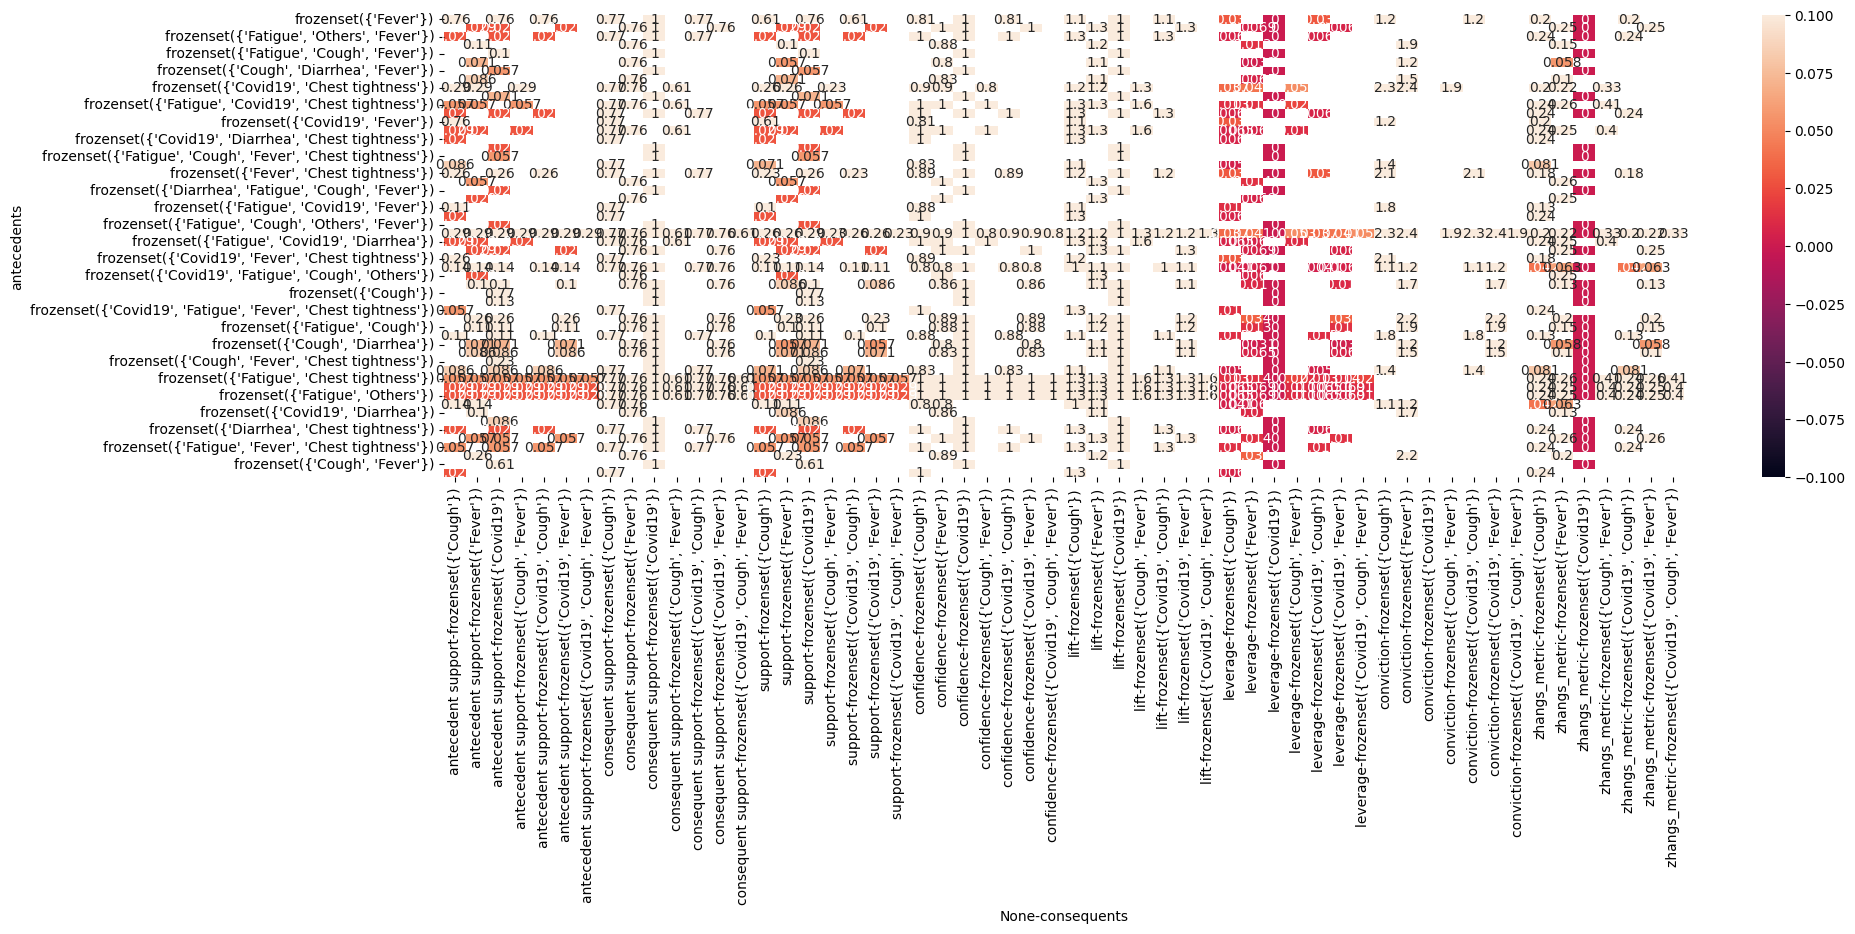

In [45]:
matrix = rules.pivot('antecedents','consequents') 
plt.figure(figsize=(20,6))
sns.heatmap(matrix,annot=True)